<a href="https://colab.research.google.com/github/fersoler/LogiCoLab/blob/main/LPOLengSem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lenguaje y semántica de la lógica de primer orden

Este cuaderno forma parte del [proyecto *LogiCoLab*](https://github.com/fersoler/LogiCoLab), publicado con licencia MIT.

👇 Para cargar las funciones que se utilizan a lo largo del cuaderno, pulsar sobre ▶ en el siguiente bloque y esperar a que aparezca ✅ a la izquierda. Si no ves el signo ▶, pasa el cursor por encima de "Mostrar código".

In [1]:
#@title
from IPython.display import display, HTML, Math, Latex
from networkx.drawing.nx_pydot import graphviz_layout
import nltk
from nltk import *
from nltk.sem import logic
from nltk.sem.logic import *
import networkx as nx
import graphviz
import pydot

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings("ignore")

read_expr = logic.Expression.fromstring

def fmlTree(G, fml, nodeN, parN = 0):
  if(parN != 0):
    G.add_edge(parN, nodeN)
  tf = type(fml)
  if (tf == IndividualVariableExpression):
    G.add_node(nodeN,label=fml.variable.name, shape='rect', color='blue')
    return
  if (tf == ApplicationExpression):
    namePred = fml.pred
    namePred = namePred.variable.name
    G.add_node(nodeN,label=namePred, shape='rect', color='blue')
    fmlArgs = fml.args
    for i in range(len(fmlArgs)):
      fmlTree(G, fmlArgs[i], str(nodeN)+str(i), nodeN)
    return
  if (tf == EqualityExpression):
    G.add_node(nodeN,label='=', shape='rect', color='blue')
    fmlTree(G, fml.first, str(nodeN)+str(1), nodeN)
    fmlTree(G, fml.second, str(nodeN)+str(2), nodeN)
    return
  if (tf == NegatedExpression):
    G.add_node(nodeN,label='¬', shape='rect', color='blue')
    fmlTree(G, fml.term, str(nodeN)+str(1), nodeN)
    return
  if (tf == AndExpression):
    G.add_node(nodeN,label='∧', shape='rect', color='blue')
    fmlTree(G, fml.first, str(nodeN)+str(1), nodeN)
    fmlTree(G, fml.second, str(nodeN)+str(2), nodeN)
    return
  if (tf == OrExpression):
    G.add_node(nodeN,label='∨', shape='rect', color='blue')
    fmlTree(G, fml.first, str(nodeN)+str(1), nodeN)
    fmlTree(G, fml.second, str(nodeN)+str(2), nodeN)
    return
  if (tf == ImpExpression):
    G.add_node(nodeN,label='→', shape='rect', color='blue')
    fmlTree(G, fml.first, str(nodeN)+str(1), nodeN)
    fmlTree(G, fml.second, str(nodeN)+str(2), nodeN)
    return
  if (tf == IffExpression):
    G.add_node(nodeN,label='↔', shape='rect', color='blue')
    fmlTree(G, fml.first, str(nodeN)+str(1), nodeN)
    fmlTree(G, fml.second, str(nodeN)+str(2), nodeN)
    return
  if (tf == AllExpression):
    G.add_node(nodeN,label='∀', shape='rect', color='blue')
    G.add_node(str(nodeN)+str(1), label=fml.variable.name, shape='rect', color='blue')
    G.add_edge(str(nodeN), str(nodeN)+str(1))
    fmlTree(G, fml.term, str(nodeN)+str(2), nodeN)
    return
  if (tf == ExistsExpression):
    G.add_node(nodeN,label='∃', shape='rect', color='blue')
    G.add_node(str(nodeN)+str(1), label=fml.variable.name, shape='rect', color='blue')
    G.add_edge(str(nodeN), str(nodeN)+str(1))
    fmlTree(G, fml.term, str(nodeN)+str(2), nodeN)
    return

#fml = read_expr('all x (R(x) -> some y. P(x,y))')

def analizaFml(cadenaFml):
  cadena = cadenaFml
  cadena = cadena.replace('¬','-')
  cadena = cadena.replace('todos','all')
  cadena = cadena.replace('todo','all')
  cadena = cadena.replace('algunos','some')
  cadena = cadena.replace('alguno','some')
  cadena = cadena.replace('algún','some')
  cadena = cadena.replace('algun','some')
  cadena = cadena.replace('existen','some')
  cadena = cadena.replace('existe','some')
  return read_expr(cadena)

def printLaTeX(nltkForm):
  cadena = str(nltkForm)
  cadena = cadena.replace('all',' \\forall ')
  cadena = cadena.replace('exists',' \\exists ')
  cadena = cadena.replace('|',' \\lor ')
  cadena = cadena.replace('&',' \\land ')
  cadena = cadena.replace('<->',' \\leftrightarrow ')
  cadena = cadena.replace('->',' \\to ')
  cadena = cadena.replace('-',' \\lnot ')
  cadena = cadena.replace('.',' ')
  return cadena

def printTXT(nltkForm):
  cadena = str(nltkForm)
  cadena = cadena.replace('all','∀')
  cadena = cadena.replace('exists','∃')
  cadena = cadena.replace('|','∨')
  cadena = cadena.replace('&','∧')
  cadena = cadena.replace('<->','↔')
  cadena = cadena.replace('->','→')
  cadena = cadena.replace('-','¬')
  cadena = cadena.replace('.',' ')
  return cadena

def fmlEvalFOL(G, fml, nodeN, parN, val, dom, assig, maxCt):
  if(parN != 0):
    G.add_edge(parN, nodeN, dir='back')
  tf = type(fml)

  valM = Valuation(val)
  mM = Model(dom, valM)
  gAss = Assignment(dom, assig)
  truthVal = mM.evaluate(str(fml), gAss)  

  if (tf == IndividualVariableExpression):
    G.add_node(nodeN,label="I("+fml.variable.name+") = "+str(truthVal), 
               shape='rect', color='blue')
    return

  color = 'black'
  if(truthVal == True):
    color = 'green'
  if(truthVal == False):
    color = 'red'

  if (tf == ApplicationExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    fmlArgs = fml.args
    theLabel = ""
    for i in range(len(fmlArgs)):
      subF = fmlArgs[i]
      truthVal = mM.evaluate(str(subF), gAss)
      theLabel = theLabel + "\n"+"I("+subF.variable.name+") = "+str(truthVal)
    theLabel = theLabel.lstrip("\n")
    G.add_node(nodeN+"1",label=theLabel, shape='rect', color='blue')
    G.add_edge(str(nodeN), str(nodeN)+"1", dir = 'back')
    return
  if (tf == EqualityExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    if (type(fml.first) == IndividualVariableExpression) & (type(fml.second) == IndividualVariableExpression):
      fmlArgs = [fml.first, fml.second]
      theLabel = ""
      for i in range(len(fmlArgs)):
        subF = fmlArgs[i]
        truthVal = mM.evaluate(str(subF), gAss)
        theLabel = theLabel + "\n"+"I("+subF.variable.name+") = "+str(truthVal)
      theLabel = theLabel.lstrip("\n")
      G.add_node(nodeN+"1",label=theLabel, shape='rect', color='blue')
      G.add_edge(str(nodeN), str(nodeN)+"1", dir = 'back')
      return
    else:
      fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
      fmlEvalFOL(G, fml.second, str(nodeN)+str(2), nodeN, val, dom, assig, maxCt)
      return
  if (tf == NegatedExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    fmlEvalFOL(G, fml.term, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
    return
  if (tf == AndExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    if(truthVal == True) | (evaluacion == "exhaustiva"):
      fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
      fmlEvalFOL(G, fml.second, str(nodeN)+str(2), nodeN, val, dom, assig, maxCt)
      return
    else:
      valLeft = mM.evaluate(str(fml.first), gAss)  
      valRight = mM.evaluate(str(fml.second), gAss)
      if valLeft:
        fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      if valRight:
        fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      else:
        Gleft = nx.DiGraph()
        fmlEvalFOL(Gleft, fml.first, '1', 0, val, dom, assig, maxCt)
        nodesL = nx.number_of_nodes(Gleft)
        Gright = nx.DiGraph()
        fmlEvalFOL(Gright, fml.second, '1', 0, val, dom, assig, maxCt)
        nodesR = nx.number_of_nodes(Gright)
        if nodesL <= nodesR:
          fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        else:
          fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
  if (tf == OrExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    if(truthVal == False) | (evaluacion == "exhaustiva"):
      fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
      fmlEvalFOL(G, fml.second, str(nodeN)+str(2), nodeN, val, dom, assig, maxCt)
      return
    else:
      valLeft = mM.evaluate(str(fml.first), gAss)  
      valRight = mM.evaluate(str(fml.second), gAss)
      if not(valLeft):
        fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      if not(valRight):
        fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      else:
        Gleft = nx.DiGraph()
        fmlEvalFOL(Gleft, fml.first, '1', 0, val, dom, assig, maxCt)
        nodesL = nx.number_of_nodes(Gleft)
        Gright = nx.DiGraph()
        fmlEvalFOL(Gright, fml.second, '1', 0, val, dom, assig, maxCt)
        nodesR = nx.number_of_nodes(Gright)
        if nodesL <= nodesR:
          fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        else:
          fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
  if (tf == ImpExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    if(truthVal == False) | (evaluacion == "exhaustiva"):
      fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
      fmlEvalFOL(G, fml.second, str(nodeN)+str(2), nodeN, val, dom, assig, maxCt)
      return
    else:
      valLeft = mM.evaluate(str(fml.first), gAss)  
      valRight = mM.evaluate(str(fml.second), gAss)
      if valLeft:
        fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      if not(valRight):
        fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return
      else:
        Gleft = nx.DiGraph()
        fmlEvalFOL(Gleft, fml.first, '1', 0, val, dom, assig, maxCt)
        nodesL = nx.number_of_nodes(Gleft)
        Gright = nx.DiGraph()
        fmlEvalFOL(Gright, fml.second, '1', 0, val, dom, assig, maxCt)
        nodesR = nx.number_of_nodes(Gright)
        if nodesL <= nodesR:
          fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        else:
          fmlEvalFOL(G, fml.second, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
        return   
  if (tf == IffExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    fmlEvalFOL(G, fml.first, str(nodeN)+str(1), nodeN, val, dom, assig, maxCt)
    fmlEvalFOL(G, fml.second, str(nodeN)+str(2), nodeN, val, dom, assig, maxCt)
    return
  if (tf == AllExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    newFml = fml.term.replace(fml.variable, read_expr('u'+str(maxCt+1)))
    if (truthVal == False) & (evaluacion == "abreviada"):
      elems = dom-mM.satisfiers(fml.term, fml.variable.name, gAss)
      assign2 = assig
      assign2.append(['u'+str(maxCt+1), list(elems)[0]])
      G.add_edge(str(nodeN), str(nodeN)+str(1), dir='back',
                 label='u'+str(maxCt+1)+'/'+list(elems)[0])
      fmlEvalFOL(G, newFml, str(nodeN)+str(1), nodeN, val, dom, assign2, maxCt+1)
      return
    else:
      listDom = list(dom)
      listDom.sort()
      for i in range(len(listDom)):
        assign2 = assig
        assign2.append(['u'+str(maxCt+1), listDom[i]])
        G.add_edge(str(nodeN), str(nodeN)+str(i+1), dir='back',
                 label='u'+str(maxCt+1)+'/'+listDom[i])
        fmlEvalFOL(G, newFml, str(nodeN)+str(i+1), nodeN, val, dom, assign2, maxCt+1)
      return
  if (tf == ExistsExpression):
    G.add_node(nodeN,label=printTXT(fml), shape='rect', color=color)
    newFml = fml.term.replace(fml.variable, read_expr('u'+str(maxCt+1)))
    if (truthVal == True) & (evaluacion == "abreviada"):
      elems = mM.satisfiers(fml.term, fml.variable.name, gAss)
      assign2 = assig
      assign2.append(['u'+str(maxCt+1), list(elems)[0]])
      G.add_edge(str(nodeN), str(nodeN)+str(1), dir='back',
                 label='u'+str(maxCt+1)+'/'+list(elems)[0])
      fmlEvalFOL(G, newFml, str(nodeN)+str(1), nodeN, val, dom, assign2, maxCt+1)
      return
    else:
      listDom = list(dom)
      listDom.sort()
      for i in range(len(listDom)):
        assign2 = assig
        assign2.append(['u'+str(maxCt+1), listDom[i]])
        G.add_edge(str(nodeN), str(nodeN)+str(i+1), dir='back',
                 label='u'+str(maxCt+1)+"/"+listDom[i])
        fmlEvalFOL(G, newFml, str(nodeN)+str(i+1), nodeN, val, dom, assign2, maxCt+1)
      return



## Introducción

La **capacidad expresiva** de la lógica proposicional es
insuficiente para modelar razonamientos que requieran utilizar
conocimiento sobre **individuos** y sus **propiedades**.

> 💡 **Ejemplo:** "Si Juan es sevillano entonces es andaluz. Juan es sevillano. Por tanto, es andaluz". 
> $$JuanSev\to JuanAnd,\ JuanSev \models JuanAnd$$
>  En la formalización no aparecen ni Juan ni sus propiedades. El argumento:
>  "Todos los sevillanos son andaluces. Juan  es sevillano. Por tanto, es andaluz" no se puede formalizar en lógica proposicional. Necesitamos recursos de la lógica de predicados de primer orden:
> $$\forall x (Sev(x)\to And(x)),\ Sev(juan)\models And(juan)$$

## Lenguajes de  $\mathsf{LPO}$

**Definición (Alfabeto).**
El *alfabeto* de un lenguaje de primer orden contiene:
- Símbolos comunes (en todos los lenguajes de primer orden): 
  - Variables: $x$, $y$, $z$, $\ldots$
  - Conectivas: $\{\top,\bot,\lnot,\land,\lor,\to,\leftrightarrow\}$
  - Cuantificadores: $\{\forall,\exists\}$
  - Paréntesis
  - Símbolo de identidad: $=$
- Símbolos propios (de cada lenguaje de primer orden)
  - Conjunto de constantes: $\{a,b,c,\dots,a_1,a_2,\dots\}$
  - Conjunto de relaciones (con aridad): $\{P,Q,\dots,P_1,P_2,\dots\}$ 

También es frecuente incluir en el alfabeto símbolos de función, aunque los dejamos aparte de momento. Si denotamos como $S$ cierto conjunto de símbolos propios, $\mathcal{L}_{\mathsf{LPO}}^S$ es el lenguaje que se obtiene con él. Cuando no suponga ambigüedad, denotaremos $\mathcal{L}_{\mathsf{LPO}}$ un lenguaje cualquiera de $\mathsf{LPO}$. 

**Definición (fórmula atómica).** 
Dada cualquier relación $R$ de aridad $n$, una *fórmula atómica* tiene la forma $R(t_1,t_2,\dots,t_n)$, donde cada $t_i$ es una constante o una variable. 

Observaciones: 
- Las relaciones de aridad $1$ se denominan **predicados**. 
- La relación $=$, cuando aparece en un lenguaje, se suele escribir de forma **infija**, $t_1 = t_2$. 
- También son consideradas fórmulas atómicas $\top$ y $\bot$ (si están en el lenguaje).

**Definición (fórmula).**
El conjunto de fórmulas es el más pequeño que verifica:
- Las fórmulas atómicas son fórmulas
- Si $\alpha$ es una fórmula, también lo es $\lnot\alpha$
- Si $\alpha$ y $\beta$ son fórmulas, entonces también lo son $(\alpha\land\beta)$, $(\alpha\lor\beta)$, $(\alpha\to\beta)$, y $(\alpha\leftrightarrow\beta)$
- Si $\alpha$ es una fórmula y $x$ una variable, entonces $(\forall x \alpha)$ y $(\exists x\alpha)$ son fórmulas

Leemos $\forall x\varphi$ como «Para todo $x$, $\varphi$» y $\exists x\varphi$ como «existe un $x$ tal que $\varphi$». 

Mediante $\alpha\in\mathsf{F}_{\mathsf{LPO}}$ indicamos que $\alpha$ es una fórmula de $\mathsf{LPO}$. Por comodidad, a veces escribiremos simplemente
$\alpha\in\mathcal{L}_{\mathsf{LPO}}$. Igualmente, con $\Gamma\subseteq\mathcal{L}_{\mathsf{LPO}}$ indicamos que $\Gamma$ es un conjunto de fórmulas de $\mathsf{LPO}$. 

**Precedencia.** Las **reglas para eliminar paréntesis** operan como en lógica proposicional, asignando a los cuantificadores la misma precedencia que a la negación.

Cuando una fórmula contiene varios cuantificadores seguidos del mismo tipo, podemos escribir un solo cuantificador delante de la primera variable cuantificada (por ejemplo, $\forall x\forall y \exists z\exists w\varphi$ se podrá escribir como $\forall x y\exists z w\varphi$). También es habitual prescindir de los paréntesis en las fórmulas atómicas, escribiendo por ejemplo $Rax$ en lugar de $R(a,x)$.

> 💻 En este tema vamos a utilizar la librería `NLTK` para trabajar con fórmulas de la lógica de primer orden. La sintaxis de esta libería utiliza el símbolo `-` para la negación, pero podemos seguir empleando `¬`, dado que se reemplazará en las fórmulas introducidas. Los argumentos de un predicado tienen que ir entre paréntesis y separados por comas, no podemos escribir `Rab`, sino `R(a,b)`. Para el cuantificador universal podemos usar `forall` (es lo que internamente hace la librería), pero se pueden usar también `all`, `todo` o `todos`. Para el cuantificador existencial tenemos la posiblidad de usar `exists`, `exist`, `some`, `algun`, `alguno` o `algunos`.  
> Es importante que tras una serie de variables cuantificadas introduzcamos un punto `"."` o acotemos entre paréntesis la expresión cuantificada. La razón es que `NLTK` trabaja también con otros tipos de lógica y si introducimos `all x P(x)` puede interpretar que la cuantificación alcanza al predicado `P`. Por ello, lo correcto es escribir `all x . P(x)`. En el caso de $\forall x (P(x) \to Q(x))$, dada la precedencia de $\forall$, necesitamos el paréntesis exterior, lo que podemos escribir como `all x (P(x) -> Q(x))` o bien 
`all x . (P(x) -> Q(x))`. Si escribimos `all x . P(x) -> Q(x)`, la fórmula será interpretada como $\forall x P(x) \to Q(x)$, con la variable $x$ libre en 
$Q(x)$. 

<IPython.core.display.Math object>

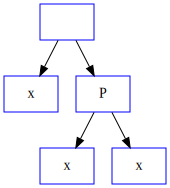

In [3]:
#@markdown # Árboles sintácticos en $\mathsf{LPO}$

#@markdown Elige una fórmula del desplegable o introduce otra
#@markdown siguiendo la sintaxis indicada más arriba 
#@markdown y pulsa ▶ para ver el árbol sintáctico.

formula = "todo x . P(x,x)" #@param ["todo x . P(x,x)", "¬ todo x existe y . R(x, y)", "todo x y (R(x,y) -> R(y,x))", "¬ todo x existe y (P(x) & Q(y) -> R(x,y))"] {allow-input: true}

try:
  fml = analizaFml(formula)
except Exception as err:
  sys.tracebacklimit = -1
  print("Ha habido un problema al procesar la fórmula, revisa la sintaxis.\n")
  raise SystemExit(err)

Math("\\text{Fórmula:}\quad "+printLaTeX(fml))
print()
G = nx.DiGraph()
fmlTree(G, fml, '1')
dot = str(nx.nx_pydot.to_pydot(G))
graphviz.Source(dot)



##Ejercicios de formalización

**Ejercicio 1**.  Formalizar los siguientes enunciados y construir el árbol sintáctico de las fórmulas resultantes. Usar los predicados indicados entre paréntesis: 
1. Las manzanas y las naranjas son gustosas y nutritivas ($P(x)$: «$x$ es una manzana»; $T(x)$: «$x$ es una naranja»; $G(x)$: «$x$ es gustoso»; $N(x)$: «$x$ es nutritivo»).
2. Hay alimentos que solo se pueden comer si han sido cocinados ($A(x)$: "$x$ es un alimento"; $M(x)$: "$x$ se puede comer"; $C(x)$: "$x$ ha sido cocinado").
3. Sin frenos, no hay ningún coche seguro ($F(x)$: "$x$ tiene frenos"; $C(x)$: "$x$ es un coche"; $S(x)$: "$x$ es seguro").
4. No todo el mundo es rico, culto y educado, ni todos los ricos son educados y cultos ($R(x)$: "$x$ es rico"; $C(x)$: "$x$ es culto"; $E(x)$: "$x$ es educado". Dominio: conjunto de todas las personas).
5. No todas las cosas compradas a bajo precio son delicadas y quebradizas ($C(x)$: "$x$ es una cosa"; $B(x)$: "$x$ ha sido comprada a bajo precio"; $F(x)$: "$x$ es delicada"; $T(x)$: "$x$ es quebradiza").

**Ejercicio 2**. Dado el predicado $A(x,y)$ que leemos como "$x$ ama a $y$" y las constantes $a$ (Antonio) y $b$ (Belén), formalizar los siguientes enunciados: 
1. Antonio ama a Belén pero belén no ama a Antonio.
2. Todo el mundo ama a Belén. 
3. Belén ama a alguien que también la ama a ella.
4. Belén ama a alguien que no es Antonio (lo cual no implica que no ame a Antonio).
5. Antonio siempre es correspondido en su amor.
6. Belén ama a una sola persona que no es ella misma. 
7. Antonio ama a exactamente a dos personas.
8. Todo el mundo se ama a sí mismo. 
9. Todo el que ama es correspondido.
10. Todo el que ama es amado.
11. Hay quien no es correspondido en su amor.
12. Todo el mundo ama a alguien distinto de sí mismo.

**Ejercicio 3**. 

Formalizar los siguientes enunciados usando los predicados $A(x,y)$ ("$x$ aprueba la asignatura $y$"), $E(x)$ ("$x$ estudia filosofía") y $F(x,y)$ ("la asignatura favorita de $x$ es $y$") y las constantes $a$ (Antonio), $b$ (belén) y $l$ (lógica).
1. La lógica no es la asignatura favorita de ningún estudiante de filosofía.
2. Hay (al menos) dos estudiantes de filosofía (distintos) que tienen la misma asignatura favorita.
3. La asignatura favorita de Antonio no es la misma que la de Belén.
4. Antonio y Belén aprueban las mismas asignaturas.
5. Todos los estudiantes de filosofía cuya asignatura favorita es la lógica, la aprueban.
6. Belén no aprueba la asignatura favorita de Antonio.
7. Belén aprueba todas las asignaturas que Antonio suspende.
8. La lógica no es la asignatura favorita de ningún estudiante de filosofía que la suspenda. 
 

## Alcance de un cuantificador, variables libres y ligadas

En una fórmula de tipo $\forall x \varphi$ o $\exists x \varphi$, se dice que el **alcance del cuantificador** correspondiente es $\varphi$. Por ejemplo,
en $\forall x (P(x,a) \to \exists y R(x,y))$, el alcance de $\forall x$ es $P(x,a) \to \exists y R(x,y)$ y el alcance de $\exists y$ es $R(x,y)$. 

Los alcances de distintos cuantificadores no se solapan parcialmente, o bien se **anidan** como en el ejemplo anterior o son **disjuntos** como en $\forall x P(x) \land \exists y Q(y)$. Cuando una variable $x$ cae bajo el alcance de un cuantificador, decimos que $x$ está **ligada** (por ese cuantificador). 
Cuando una variable $x$ no está ligada, decimos que está **libre**. 
Las fórmulas con variables libres se llaman **fórmulas abiertas** y las fórmulas sin variables libres se llaman **fórmulas cerradas** o **sentencias**. 
El **conjunto de sentencias** es una clase muy importante de fórmulas de $\mathcal{L}_{\mathsf{LPO}}$. 

## Sustituciones

Si $t$ y $u$ son términos, mediante $\varphi(t/u)$ representamos el resultado de **sustituir** en la fórmula $\varphi$ cada ocurrencia de $t$ por $u$. 
En los cálculos, será habitual **sustituir una variable** por una constante y viceversa.  Podemos representar mediante $\varphi(t_1/u_1,\dots,t_n/u_n)$ una **sustitución múltiple simultánea**.

> 💡 **Preguntas**. 
1. ¿Por qué es importante que las sustituciones múltiples se apliquen simultáneamente?
2. ¿Cuál es el efecto de una sustitución en el árbol de análisis de una fórmula?

## Semántica de $\mathsf{LPO}$

**Definición (Estructura)**. 
Una **estructura** $\mathcal{M} = \langle \mathcal{D}, \mathcal{I}\rangle{}$ consta de:
- Un conjunto enumerable y no vacío $\mathcal{D}$ llamado **dominio** o **universo de discurso**.
- Una **función de interpretación** $\mathcal{I}$, que se define:
  - Para cada constante $a$, $\mathcal{I}(a)\in \mathcal{D}$.
  - Para cada predicado $P$ de aridad $n$, $\mathcal{I}(P)\subseteq \mathcal{D}^n$. En el caso de la identidad, su interpretación es siempre $\{(x,x) \mid x\in \mathcal{D}\}$.

Dada $\mathcal{M} = \langle \mathcal{D}, \mathcal{I}\rangle{}$, indicamos mediante $\mathcal{M}'{\underset{a}{=}} \mathcal{M}$ que $\mathcal{M}'$ es una estructura igual en todo a $\mathcal{M}$ excepto, a lo sumo, en
la interpretación de la constante $a$. 

**Definición (Verdad)**. 
Dada una **sentencia** $\alpha\in\mathcal{L}_{\mathsf{LPO}}$ y una estructura $\mathcal{M} = \langle \mathcal{D}, \mathcal{I}\rangle$ para $\mathcal{L}_{\mathsf{LPO}}$, $\alpha$ recibe un **valor de verdad** $\mathcal{M}(\alpha) \in \{0,1\}$. Según sea $\alpha$,
$$
\begin{array}{lcl}
  \mathcal{M}(P(t_1,\dots,t_n)) = 1 & \text{sii} & 
  (\mathcal{I}(t_1), \dots, \mathcal{I}(t_n))\in \mathcal{I}(P)\\
  \mathcal{M}(\lnot\varphi) = 1  & \text{sii} & \mathcal{M}(\varphi) = 0\\
  \mathcal{M}(\varphi \land \psi) = 1 & \text{sii} & \mathcal{M}(\varphi) = 1 \quad
  \text{y} \quad \mathcal{M}(\psi)=1 \\
  \mathcal{M}(\varphi \lor \psi)=1 & \text{sii} & \mathcal{M}(\varphi) = 1 \quad
  \text{o} \quad \mathcal{M}(\psi)=1 \\
  \mathcal{M}(\varphi \to \psi)=1 & \text{sii} & \mathcal{M}(\varphi) = 0 \quad
  \text{o} \quad \mathcal{M}(\psi)=1 \\
  \mathcal{M}(\varphi \leftrightarrow \psi)=1 & \text{sii} & \mathcal{M}(\varphi) =
  \mathcal{M}(\psi) \\ 
  \mathcal{M}(\forall x \varphi)=1 & \text{sii} & \mathcal{M}'(\varphi(x/u)) = 1 \ 
  \text{para toda} \ \ \mathcal{M}'{\underset{u}{=}} \mathcal{M} \\
    \mathcal{M}(\exists x \varphi)=1 & \text{sii} & \mathcal{M}'(\varphi(x/u)) = 1 \ 
  \text{para alguna} \ \ \mathcal{M}'{\underset{u}{=}} \mathcal{M} 
  \end{array}
$$
En los últimos casos $u$ es cualquier constante que no ocurra en $\varphi$.

**Observaciones:**
- Cuando $\mathcal{M}(\varphi)=1$ escribimos $\mathcal{M}\models\varphi$ y decimos que $\varphi$ es **verdadera** en $\mathcal{M}$ o que $\mathcal{M}$ **satisface** $\varphi$.
- Cuando $\mathcal{M}(\varphi)=0$, escribimos $\mathcal{M}\not\models\varphi$ y decimos que $\varphi$ es **falsa** en $\mathcal{M}$. 
- Podemos extender la noción de verdad a conjuntos de fórmulas $\Gamma\subseteq\mathcal{L}_{\mathsf{LPO}}$: $\mathcal{M}(\Gamma)=1$ (o bien
$\mathcal{M}\models\Gamma$) sii para todo $\gamma\in\Gamma$ se cumple
$\mathcal{M}(\gamma)=1$. 



Estructura introducida:

Domain = {'2', '3', '1'},
Valuation = 
{'P': {('2',)},
 'Q': {('3',)},
 'R': {('1', '1'),
       ('1', '2'),
       ('1', '3'),
       ('2', '1'),
       ('2', '3'),
       ('3', '1'),
       ('3', '2'),
       ('3', '3')},
 'S': {('2', '1'), ('1', '3'), ('3', '2'), ('3', '3')},
 'a': '2',
 'b': '2'}



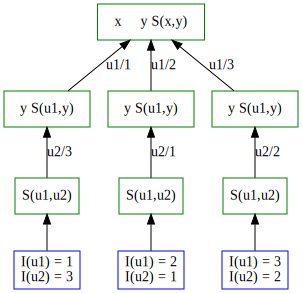

In [4]:
#@title ## Evaluación paso a paso de fórmulas en una pequeña estructura ($D = \{1, 2, 3\}$)

#@markdown Vamos a ver cómo evaluar paso a paso fórmulas de la lógica de primer
#@markdown orden en una pequeña estrucura cuyo dominio tiene solo tres elementos,
#@markdown $D = \{1, 2, 3\}$. 

#@markdown Cuando completes todos los campos e introduzcas una fórmula, pulsa sobre
#@markdown ▶ para ver su valor de verdad, así como la justificación
#@markdown paso a paso. 

#@markdown ### Individuos
#@markdown En primer lugar, determina el valor de las constantes $a$ y $b$:
ind_a = "2" #@param ["1", "2", "3"]
ind_b = "2" #@param ["1", "2", "3"]

#@markdown ### Relaciones de aridad 1 (predicados)
#@markdown Introduce la interpretación de los predicados $P$ y $Q$ de aridad 1.
#@markdown Se introducen como elementos del dominio separados por comas. 
#@markdown Si alguna interpretación se deja en blanco, ningún individio cumple
#@markdown la propiedad correspondiente. 
pred_P = "2" #@param {type:"string"}
pred_Q = "3" #@param {type:"string"}

#@markdown ### Relaciones de aridad 2
#@markdown Introduce la interpretación de las relaciones $R$ y $S$ de aridad 2.
#@markdown Se introducen como parejas de elementos del dominio separadas por 
#@markdown comas. Cada pareja `(x, y)` relaciona dos elementos del dominio.
#@markdown Si alguna interpretación de deja en blanco, ninguna pareja de individuos
#@markdown verifica la propiedad correspondiente. 
rel_R = "(1, 3), (3, 1), (1, 2), (2, 1), (2, 3), (3, 2), (1,1), (3,3)" #@param {type:"string"}
rel_S = "(1, 3), (2, 1), (3, 2), (3, 3)" #@param {type:"string"}


#@markdown ### Evaluación de fórmulas
#@markdown Introduce la fórmula que quieres evaluar y pulsa ▶ (izquierda). 
formula = "todo x. algun y. S(x, y)" #@param ["todo x (P(x) & Q(x) -> todo y. R(y, x))", "todo x (P(x) & Q(x) -> R(x, x))", "algun x . algun y (R(x,y) & R(y,x))"] {allow-input: true}

#@markdown Puedes elegir el grado de detalle de la justificación. La `abreviada`
#@markdown es una justificación suficiente del valor de verdad correspondiente
#@markdown a la fórmula introducida. 
evaluacion = "abreviada" #@param ["abreviada", "exhaustiva"]

try:
  v2 = []
  if(ind_a.strip() != ''):
    v2.append(("a", ind_a))
  if(ind_b.strip() != ''):
    v2.append(("b", ind_b))
  intP = set2rel([])
  if(pred_P.strip() != ''):
    intP = {e.strip() for e in pred_P.split(',')}
  v2.append(("P", intP))
  intQ = set2rel([])
  if(pred_Q.strip() != ''):
    intQ = {e.strip() for e in pred_Q.split(',')}
  v2.append(("Q", intQ))

  allN = rel_R.replace('(','').replace(')','').replace(' ','').split(',')
  pairs = set2rel({(allN[2*i], allN[2*i+1]) for i in range((len(allN)//2))})
  v2.append(("R", pairs))

  allN = rel_S.replace('(','').replace(')','').replace(' ','').split(',')
  pairs = set2rel({(allN[2*i], allN[2*i+1]) for i in range((len(allN)//2))})
  v2.append(("S", pairs))

  fmla = analizaFml(formula)
except Exception as err:
  sys.tracebacklimit = -1
  print("Ha habido un problema al procesar la fórmula, revisa la sintaxis.\n")
  raise SystemExit(err)
  

dom2 = set(["1", "2", "3"])


val1 = Valuation(v2)
m1 = Model(dom2, val1)
g1 = Assignment(dom2, [])
print()
print("Estructura introducida:\n")
print(m1)
print()


G = nx.DiGraph()
fmlEvalFOL(G, fmla, '1', 0, v2, dom2, [], 0)
dot = str(nx.nx_pydot.to_pydot(G))
graphviz.Source(dot)

In [5]:
#@title ## Interpretación de fórmulas en dominios finitos mayores

#@markdown En esta ocasión, podemos usar estructuras con dominios mayores,
#@markdown por lo que se mostrará el valor de verdad de la fórmula y no
#@markdown su justificación. 

#@markdown Completa todos los campos y pulsa ▶ (izquierda) para ealuar las fórmulas
#@markdown propuestas en la estructura que se ha construido. 

#@markdown ### Individuos
#@markdown Introduce la interpretación de cada una de las constantes $a$, $b$ y 
#@markdown $c$. También puedes indicar otros elementos del dominio. Si se deja en
#@markdown blanco la interpretación de alguna constante, no se podrá evaluar ninguna
#@markdown fórmula que la contenga. 
ind_a = "1" #@param {type:"string"}
ind_b = "2" #@param {type:"string"}
ind_c = "3" #@param {type:"string"}
otros = "4, 5, 6" #@param {type:"string"}

#@markdown ### Relaciones de aridad 1 (predicados)
#@markdown Introduce la interpretación de los predicados $P$ y $Q$ de aridad 1.
#@markdown Se introducen como elementos del dominio separados por comas. 
#@markdown Si alguna interpretación se deja en blanco, ningún individio cumple
#@markdown la propiedad correspondiente. 
pred_P = "1, 2, 3, 4" #@param {type:"string"}
pred_Q = "1, 2" #@param {type:"string"}

#@markdown ### Relaciones de aridad 2
#@markdown Introduce la interpretación de las relaciones $R$ y $S$ de aridad 2.
#@markdown Se introducen como parejas de elementos del dominio separadas por 
#@markdown comas. Cada pareja `(x, y)` relaciona dos elementos del dominio.
#@markdown Si alguna interpretación de deja en blanco, ninguna pareja de individuos
#@markdown verifica la propiedad correspondiente. 
rel_R = "(1, 3), (2, 4), (2, 1)" #@param {type:"string"}
rel_S = "(3, 3), (4, 1)" #@param {type:"string"}

#@markdown ### Evaluación de fórmulas
#@markdown Introduce la fórmula que quieres evaluar y pulsa ▶ (izquierda). 
formula = "todo x (algun y . R(x,y) -> x != c)" #@param {type:"string"}

try:
  v2 = []
  if(ind_a.strip() != ''):
    v2.append(("a", ind_a))
  if(ind_b.strip() != ''):
    v2.append(("b", ind_b))
  if(ind_c.strip() != ''):
    v2.append(("c", ind_c))
  intP = set2rel([])
  if(pred_P.strip() != ''):
    intP = {e.strip() for e in pred_P.split(',')}
  v2.append(("P", intP))
  intQ = set2rel([])
  if(pred_Q.strip() != ''):
    intQ = {e.strip() for e in pred_Q.split(',')}
  v2.append(("Q", intQ))

  allN = rel_R.replace('(','').replace(')','').replace(' ','').split(',')
  pairs = set2rel({(allN[2*i], allN[2*i+1]) for i in range((len(allN)//2))})
  v2.append(("R", pairs))

  allN = rel_S.replace('(','').replace(')','').replace(' ','').split(',')
  pairs = set2rel({(allN[2*i], allN[2*i+1]) for i in range((len(allN)//2))})
  v2.append(("S", pairs))

  val2 = Valuation(v2)
  dom2 = val2.domain
  dom2 = dom2.union(set(otros.replace(' ','').split(',')))
  m2 = Model(dom2, val2)
  g2 = Assignment(dom2, [])

  fmla = str(analizaFml(formula))
except Exception as err:
  sys.tracebacklimit = -1
  print("Ha habido un problema al procesar la fórmula, revisa la sintaxis.\n")
  raise SystemExit(err)

print()
print("Extructura definida\n")
print(m2)
print()

Math("\\text{El valor de verdad de }\\quad"+printLaTeX(fmla)+
     " \\quad\\text{es:}\\quad\\text{" + str(m2.evaluate(fmla,g2)) +"}")


Extructura definida

Domain = {'6', '4', '2', '3', '1', '5'},
Valuation = 
{'P': {('3',), ('4',), ('1',), ('2',)},
 'Q': {('1',), ('2',)},
 'R': {('2', '4'), ('1', '3'), ('2', '1')},
 'S': {('3', '3'), ('4', '1')},
 'a': '1',
 'b': '2',
 'c': '3'}



<IPython.core.display.Math object>

## Crea tu propia estructura en `NLTK` para evaluar fórmulas de $\mathsf{LPO}$

Ahora puedes trabajar directamente con la librería `NLTK` para definir un modelo y evaluar fórmulas de la lógica de primer orden. Los comentarios del código muestran cómo hacerlo. 

In [6]:
#@title
myV = [('carmen', 'i1'),                # Constantes y sus interpretaciones
       ('juan', 'i2'),
       ('ana', 'i3'),
       ('pedro', 'i4'),
       ('Filo', set(['i1', 'i4'])),     # Predicados
       ('Sev', set(['i1', 'i3'])),
       ('Psic', set([])),                 # (no hay ninguno)
       ('Ama', set([('i1', 'i4'), ('i4', 'i3')])) # Relaciones
       ]

myVal = Valuation(myV)        # Interpretación
myDom = myVal.domain          # Inferimos dominio de la interpretación
myG = Assignment(myDom)       # Asignación de variables libres
myModel = Model(myDom, myVal) # Construcción de la estructura

# Lista de fórmulas que vamos a evaluar
listaFmls = [
    # Carmen ama a Juan
    "Ama(carmen, juan)",
    # Carmen ama a Pedro
    "Ama(carmen, pedro)",
    # Carmen es filósofa y sevillana
    "Filo(carmen) & Sev(carmen)",
    # Todo filósofo ama a algún sevillano
    "todo x (Filo(x) -> algun y (Ama(x,y) & Sev(y)))",
    # Todos los psicólogos son sevillanos
    "todo x (Psic(x) -> Sev(x))",
    # Algún sevillano ama a un filósofo
    "algun x (Sev(x) & algun y (Filo(y) & Ama(x,y)))"
    ]

print("Estructura definida:")
print(myModel)

print("\nValores de verdad:\n")

# Analiza y evalúa cada una de las fórmulas
for fml in listaFmls:
  laForm = str(analizaFml(fml))
  Math("\\text{El valor de verdad de }\\quad "+printLaTeX(laForm)+
       " \\quad\\text{es:} \\quad\\text{" + str(myModel.evaluate(laForm,myG)) +"}")

Estructura definida:
Domain = {'i2', 'i1', 'i4', 'i3'},
Valuation = 
{'Ama': {('i1', 'i4'), ('i4', 'i3')},
 'Filo': {('i1',), ('i4',)},
 'Psic': set(),
 'Sev': {('i1',), ('i3',)},
 'ana': 'i3',
 'carmen': 'i1',
 'juan': 'i2',
 'pedro': 'i4'}

Valores de verdad:



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

El código de más abajo te permite ver la justificación del valor de verdad de una fórmula en la estructura que has introducido en el código anterior. Puedes adaptarlo para resolver ejercicios.

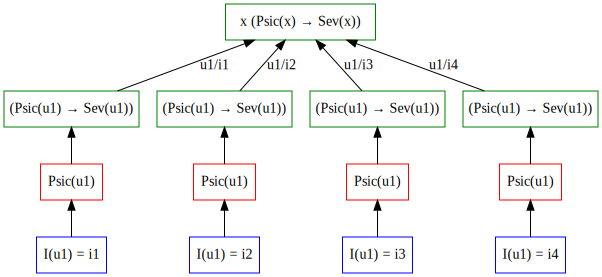

In [8]:
evaluacion = "abreviada" # abreviada/exhaustiva
fmla = analizaFml("todo x (Psic(x) -> Sev(x))")
#fmla = analizaFml("todo x (Filo(x) -> Sev(x))")
#fmla = analizaFml("Ama(carmen, pedro)")
G = nx.DiGraph()
fmlEvalFOL(G, fmla, '1', 0, myV, set(myDom), [], 0)
dot = str(nx.nx_pydot.to_pydot(G))
graphviz.Source(dot)

## Satisfacibilidad, validez, consecuencia lógica

Las nociones semánticas en $\mathsf{LPO}$ son las mismas
que en lógica proposicional:
- La fórmula $\varphi\in\mathcal{L}_{\mathsf{LPO}}$ es **satisfacible** sii existe $\mathcal{M}$ tal que $\mathcal{M}\models\varphi$. Podemos indicarlo mediante $\varphi\not\models\bot$. 
- La fórmula $\varphi$ es **contradictoria** sii no es satisfacible, escribimos entonces $\varphi\models\bot$.
- El conjunto de fórmulas $\Gamma\subseteq\mathcal{L}_{\mathsf{LPO}}$ es **satisfacible** sii existe $\mathcal{M}$ tal que $\mathcal{M}\models\Gamma$. Podemos indicarlo mediante $\Gamma\not\models\bot$. 
- La fórmula $\varphi$ es **válida** (o **universalmente válida**, o **tautológica**) sii para toda estructura $\mathcal{M}$, se verifica $\mathcal{M}\models\varphi$. En ese caso, escribimos $\models\varphi$. Mediante $\not\models\varphi$ indicamos que $\varphi$ no es válida. 
- La fórmula $\varphi$  es **consecuencia lógica** del conjunto de fórmulas $\Gamma$ sii para toda estructura $\mathcal{M}$ se cumple que $\mathcal{M}\models\Gamma$ implica $\mathcal{M}\models\varphi$. En ese caso, escribimos $\Gamma\models\varphi$. Cuando $\varphi$ no es consecuencia lógica de $\Gamma$ escribimos $\Gamma\not\models\varphi$. 

En $\mathsf{LPO}$ no podemos hacer tablas de verdad que comprueben el valor de verdad de una cierta fórmula en todas las estructuras posibles. En ocasiones, podemos razonar acerca de si una fórmula $\varphi$ es o no satisfacible, o consecuencia lógica de cierto conjunto $\Gamma$. Los cálculos que veremos en los próximos temas permiten comprobar las nociones semánticas en $\mathsf{LPO}$ de modo sistemático. 

## Ejercicios de semántica de $\mathsf{LPO}$

**Ejercicio 1**. Crea estructuras con un dominio de 4 elementos donde se hagan verdaderas las fórmulas del ejercicio 2 de formalización. Utiliza el código de arriba para comprobar que las fórmulas son verdaderas. 

**Ejercicio 2**. Argumentar cómo podría justificarse el siguiente silogismo utilizando las definiciones semánticas: "Los caracoles son gasterópodos. Los gasterópodos son moluscos. Por tanto, los caracoles son moluscos". 

**Ejercicio 3**. Detectar las diferencias semánticas entre las siguientes fórmulas ofreciendo estructuras que las satisfagan: 
- $\exists x \exists y \ R(x,y)$
- $\forall x \forall y \ R(x,y)$
- $\exists x \forall y \ R(x,y)$
- $\forall x \exists y \ R(x,y)$
- $\exists y \forall x \ R(x,y)$

**Ejercicio 4**. Para cada uno de los siguientes conjuntos de sentencias, proponer una estructura que lo satisfaga. Intentar que los dominios tengan la menor cardinalidad posible: 
- $\{P(a),\ P(b),\ P(c),\ P(d)\}$
- $\{\forall x (\lnot P(x) \to R(x,x)), \forall x ( P(x)\leftrightarrow \lnot Q(x)), P(a),$ $\exists x Q(x)\}$
- $\{\exists x y z (x\neq y \land y\neq z\land x\neq z), \forall x R(x,x), \forall xy (R(x,y)\to R(y,x)), \forall xyz (R(x,y)\land R(y,z)\to R(x,z))\}$

**Ejercicio 5**. Justificar qué requisitos impone cada una de las siguientes sentencias a la cardinalidad de $\mathcal{D}$ para que $\mathcal{M} = \langle \mathcal{D}, \mathcal{I}\rangle$ pueda satisfacerlas:
- $\exists xy (x\neq y)$
- $\exists xy (x\neq y \land \forall z (z = x \lor z = y))$
- $\forall x\exists y R(x,y)\land \forall x\forall y (R(x,y)\to \lnot R(y,x)) \land \forall xyz (R(x,y)\land R(y,z)\to R(x,z))$

## Formalización de oraciones en lenguaje natural

La semántica computacional es el campo la IA que se encarga de que las máquinas puedan asignar una interpretación a las oraciones del lenguaje natural. Es una de las áreas del Procesamiento del Lenguaje Natural (simbólico) donde la lógica de predicados de primer orden ha tenido más aplicación. Las oraciones del lenguaje natural se analizan mediante gramáticas que asignan una forma lógica que luego puede interpretarse. Si tenemos una estructura $\mathcal{M}$ que se corresponde con nuestra representación del mundo, la evaluación de la forma lógica de una oración en $\mathcal{M}$ nos indica si la fórmula es o no verdadera. 

La librería `NLTK` permite usar la lógica de primer orden junto con las gramáticas formales para hacer semántica computacional. Vamos a ver un ejemplo del tutorial de `NLTK`. Para más información se pueden consultar los [libros de Blackburn y Boss](http://www.let.rug.nl/bos/comsem/). 

Descargamos gramáticas de `NLTK`:

In [9]:
nltk.download('sample_grammars')

[nltk_data] Downloading package sample_grammars to /root/nltk_data...
[nltk_data]   Unzipping grammars/sample_grammars.zip.


True

Podemos obtener la forma lógica de diferentes oraciones y evaluarlas semánticamente en un modelo:

In [10]:
import nltk.data
from nltk.sem.util import parse_sents

# Estructura de ejemplo: 
val = nltk.data.load('grammars/sample_grammars/valuation1.val')
dom = val.domain
m = Model(dom, val)
g = Assignment(dom)
print("Model:")
print(m)

# Gramática: 
gramfile = 'grammars/sample_grammars/sem2.fcfg'

# Oraciones que queremos analizar: 
inputs = ['John sees a girl', 'every dog barks', 'every boy barks', 
          'a girl sees a boy', 'a girl sees a dog']

# Analizamos: 
parses = parse_sents(inputs, gramfile)
# Mostramos el análisis de cada oración junto con su forma 
# lógica y valor de verdad: 
for sent, trees in zip(inputs, parses):
  print()
  print("Sentence: %s" % sent)
  for tree in trees:
    print("Parse:\n %s" %tree)
    fmla = root_semrep(tree)
    print("Semantics: %s" %  fmla)
    print("Truth value: %s" % m.evaluate(str(fmla),g))

Model:
Domain = {'b1', 'b2', 'd1', 'd2', 'g2', 'n', 'g1'},
Valuation = 
{'bark': {('d1',), ('d2',)},
 'boy': {('b1',), ('b2',)},
 'chase': {('b2', 'g1'), ('b1', 'g1'), ('g1', 'd1'), ('g2', 'd2')},
 'dog': {('d1',), ('d2',)},
 'fido': 'd1',
 'girl': {('g2',), ('g1',)},
 'in': {('b1', 'n'), ('d2', 'n'), ('b2', 'n')},
 'john': 'b1',
 'mary': 'g1',
 'noosa': 'n',
 'see': {('b2', 'd2'), ('g2', 'n'), ('g1', 'b1'), ('b1', 'g1'), ('d2', 'b1')},
 'suzie': 'g2',
 'tess': 'd2',
 'walk': {('g2',), ('d1',), ('b1',)},
 'with': {('g1', 'b1'), ('d1', 'b1'), ('b1', 'g1'), ('b1', 'd1')}}

Sentence: John sees a girl
Parse:
 (S[SEM=<exists x.(girl(x) & see(john,x))>]
  (NP[-LOC, NUM='sg', SEM=<\P.P(john)>]
    (PropN[-LOC, NUM='sg', SEM=<\P.P(john)>] John))
  (VP[NUM='sg', SEM=<\y.exists x.(girl(x) & see(y,x))>]
    (TV[NUM='sg', SEM=<\X y.X(\x.see(y,x))>, TNS='pres'] sees)
    (NP[NUM='sg', SEM=<\Q.exists x.(girl(x) & Q(x))>]
      (Det[NUM='sg', SEM=<\P Q.exists x.(P(x) & Q(x))>] a)
      (Nom[NUM='sg',